In [1]:
import numpy as np
from collections import Counter
from sklearn.datasets import fetch_openml, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import xgboost as xgb
from copy import deepcopy

import pandas as pd # Used only to import data
import io
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score

import matplotlib.pyplot as plt
import csv

### Load dataset

Rows are examples, columns are features. Data should be loaded as a numpy array. If X (features) has shape (n,m), y (labels) needs to have shape (n,). 

In [2]:
# Upload data
from google.colab import files # change to work locally using Jupyter
uploaded = files.upload()

Saving Telco1.csv to Telco1.csv
Saving Telco2.csv to Telco2.csv


In [3]:
telco1 = pd.read_csv(io.BytesIO(uploaded['Telco1.csv']))
telco2 = pd.read_csv(io.BytesIO(uploaded['Telco2.csv']))

In [4]:
# Use Label Encoder for categorical (not binary) features
# (not recommended according to xgb documentation)
def label_encode(df):
    cate = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['bool', 'object']]
    # print(cate)
    le = LabelEncoder()
    for i in cate:
        le.fit(df[i])
        df[i] = le.transform(df[i])
    return df

In [5]:
telco_dataset = 1 # choose either 1 or 2

if telco_dataset == 1:
    df = telco1
    op1 = 'phone number'
    op2 = 'churn'
else:
    df = telco2
    op1 = 'customerID'
    op2 = 'Churn'
    #op3 =    # categorical features to one-hot encode

df = df.drop([op1],axis=1) # drop customer ID or phone number

# Separate and rewrite churn outcomes
le = LabelEncoder()
y = df[op2]
df = df.drop([op2],axis=1)
y = le.fit_transform(y)

df = label_encode(df)
features = list(df.columns) # Use for SHAP demo later
X = df.to_numpy()

In [ ]:
# Alternative datasets for testing

# X=[]
# y = []
   
# # X, y = fetch_openml('clean1', version=1, return_X_y=True)
# X, y = fetch_openml('codrna', version=1, return_X_y=True)
# y = y.astype(float)
# y = (y+1)/2
# y = y.astype(int)

#X, y = make_classification(n_samples=50000, n_features=5, n_redundant=0, n_informative=3,
#                           random_state=1, n_clusters_per_class=1) # X is a (50000, 5) numpy array, y is 50000 1d numpy array


# X=[]
# y = []
   
# X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# y = y.astype(int)


### Helper functions

In [6]:
def sigmoid(x):
    return 1/(1+ np.exp(-x))

# Log loss for logistic regression
def cust_obj(preds, training):
    labels = training.get_label()
    preds = sigmoid(preds)
    grad = preds - labels
    hess = preds*(1-preds)
    return grad, hess

def hash(vectors, X, y, L = None, hash_output = False, verbose = False):
    num_dim = len(X[0])

    if L == None:
        L = min(40, num_dim-1) 
    
    r = 4.0
    mu = 0.0
    sigma = 1.0
    hash_functions = []
    for l in range(L):
        hash_function = []
        a = np.random.normal(mu, sigma, num_dim)
        b = np.random.uniform(0, r, 1)
        hash_function.append(a)
        hash_function.append(b)
        hash_functions.append(hash_function)

    if hash_output:
        print("\nHash functions:\n")
        print(hash_functions)

    hash_values = []
    counters = []
    for party in vectors:
        party_hashes = []
        party_counters = []
        for vector in party[0]:
            hashes = []
            for hash_index in range(L):
                hash_val = (np.dot(hash_functions[hash_index][0], vector) + hash_functions[hash_index][1])/r
    #             hash_val = ((hash_functions[hash_index][0].dot(vector)) + hash_functions[hash_index][1])/r
                hash_val = np.floor(hash_val)
                hash_val_float = hash_val[0]
                hashes.append(hash_val_float)
            party_counters.append(Counter(hashes))
            party_hashes.append(hashes)
        hash_values.append(party_hashes)
        counters.append(party_counters)

    hash_tables = []
    if verbose: print("\nBuilding hash tables:\n")
    for m in tqdm(range(len(vectors)), disable = not verbose):
        if verbose: print(m)
        hash_table = np.zeros((len(vectors[m][0]), len(vectors))) #For each party, build a hash table of dim numInstances x numParties. 
        for i in range(len(vectors[m][0])):   #Select an instance x_i in m party
            for j in range(len(vectors)):  #Select parties to find global instances from
                if j == m:
                    hash_table[i][j] = i
                else:
                    instance_hash_counts = {}
                    for k in range(len(counters[j])):   #Select instance k in other parties
                        instance_hash_counts[k] = 0
                        for value in counters[m][i].keys():  #Iterate through hash values of x_i^m
                            if counters[j][k][value] != 0:
                                instance_hash_counts[k] += min(counters[j][k][value], counters[m][i][value])
                    hash_table[i][j] = max(instance_hash_counts, key=instance_hash_counts.get)
        hash_tables.append(hash_table)
        
    if hash_output:
        print("\nHash tables:\n")
        print(hash_tables)
        print("\nLength of hash tables:", len(hash_tables))
    
    return hash_tables



### Accuracy loss comparisons for one dataset

In [7]:
# Returns accuracy loss of model trained on n federated 
# datasets using SimFL, ALL-IN, and SOLO (avg'd across the datasets).
# params = parameters for XGBoost

def accuracy_losses(X, y, params = {'max_depth': 8}, num_parties = 3, L = None, hash_output = False, verbose = False):

    print('Start\n')
    if verbose: print('XGBoost parameters: ', params, '; Number of Parties: ', num_parties)
    
    # Randomizing X, y, and separating train/test sets randomly
    # The two lines below are equivalent but may differ due to rounding depending on size of dataset
    holdout_X, X, holdout_y, y = train_test_split(X, y, train_size=0.25, random_state=42)
    #X, holdout_X, y, holdout_y = train_test_split(X, y, test_size=0.25, random_state=42)

    vectors=[]
    # print("Original number of data points: ", len(X))

    for j in range(0, int(len(X)), int(len(X)/num_parties)):
        partyX = []
        partyY = []
        for i in range(j, min(j+int(len(X)/num_parties), int(len(X)))):
            partyX.append(X[i])
            partyY.append(y[i])
        vectors.append((partyX, partyY))

    hash_tables = hash(vectors, X, y, L, hash_output, verbose)

    num_parties = len(vectors)
    if verbose: print("Data points per party: ", len(vectors[0][0]))

    xgb_parties = []
    for party in vectors:
        xgb_parties.append(xgb.DMatrix(np.asarray(party[0]), label=np.asarray(party[1])))
    
    model = xgb.Booster(params, [xgb_parties[0]])

    G = []
    H = []
    for i in range(len(vectors)):
        G.append([])
        H.append([])
    
    for m in tqdm(range(2*len(vectors)), disable = not verbose): #Select central processing party that receives gradients from others
        m_ind = m % len(vectors)
        for i in range(len(vectors)): 
            if i != m_ind:
                Gi = np.zeros((len(vectors), len(vectors[m_ind][0])))
                Hi = np.zeros((len(vectors), len(vectors[m_ind][0])))
                for q in range(len(vectors[i][0])):
                    s = int(hash_tables[i][q][m_ind])
                    dtrain = xgb.DMatrix(np.asarray([vectors[i][0][q]]), label=np.asarray([vectors[i][1][q]]))
                    dpred_inst = model.predict(dtrain)
                    grad, hess = cust_obj(dpred_inst, dtrain)
                    Gi[m_ind][s] += grad
                    Hi[m_ind][s] += hess
                G[i] = Gi
                H[i] = Hi
        Gm = np.zeros((len(vectors), len(vectors[m_ind][0])))
        Hm = np.zeros((len(vectors), len(vectors[m_ind][0])))
        for q in range(len(vectors[m_ind][0])):
            for i in range(len(vectors)):
                if i == m_ind:
                    dtrain = xgb.DMatrix(np.asarray([vectors[m_ind][0][q]]), label=np.asarray([vectors[m_ind][1][q]]))
                    dpred_inst = model.predict(dtrain)
                    grad, hess = cust_obj(dpred_inst, dtrain)
                    Gm[m_ind][q] += grad
                    Hm[m_ind][q] += hess
                else:
                    Gm[m_ind][q] += G[i][m_ind][q]
                    Hm[m_ind][q] += H[i][m_ind][q]
        G[m_ind] = Gm
        H[m_ind] = Hm
        
        m_dtrain = xgb_parties[m_ind]
        model.boost(m_dtrain, Gm[m_ind], Hm[m_ind])
    
    # SimFL: federated data sets
    dtest = xgb.DMatrix(np.asarray(holdout_X[:int(len(holdout_X))]), label=np.asarray(holdout_y[:int(len(holdout_y))]))
    test_preds = model.predict(dtest)
    test_preds = sigmoid(test_preds)
    test_preds_labels = np.round(test_preds)
    simfl_conf = confusion_matrix(holdout_y[:int(len(holdout_y))], test_preds_labels)
    if verbose: print("\nSimFL confusion matrix:\n", simfl_conf)


    # ALL: Using all data, not federated
    dtrainAll = xgb.DMatrix(np.asarray(X[:int(len(X))]), label=np.asarray(y[:int(len(y))]))
    paramsAll = params
    modelAll = xgb.Booster(params, [dtrainAll])
    for i in tqdm(range(20), disable = not verbose):
        predictions = modelAll.predict(dtrainAll)
        g,h = cust_obj(predictions, dtrainAll)
        modelAll.boost(dtrainAll,g,h)
    test_preds_all = modelAll.predict(dtest)
    test_preds_all = sigmoid(test_preds_all)
    test_preds_labels_all = np.round(test_preds_all)
    all_conf = confusion_matrix(holdout_y[:int(len(holdout_y))], test_preds_labels_all)
    if verbose: print("\nALL confusion matrix:\n", all_conf)

    # SOLO: Using data only from one party
    conf_solo = []
    for i in range(len(vectors)):
        param_solo = params
        model_solo = xgb.Booster(param_solo, [xgb_parties[i]])
        dtrain = xgb_parties[i]
        for m in (range(2*(len(vectors)))):
            predictions = model_solo.predict(dtrain)
            g,h = cust_obj(predictions, dtrain)
            model_solo.boost(dtrain, g,h)
        test_preds_solo = model_solo.predict(dtest)
        test_preds_solo = sigmoid(test_preds_solo)
        test_labels_solo  = np.round(test_preds_solo)
        conf_solo.append(confusion_matrix(holdout_y, test_labels_solo))
    if verbose: print("\nSOLO confusion matrix:\n", conf_solo)

    # "Naive" federated learning: pass one model around
    '''nfl_confs = []

    for i in range(1,len(vectors)+1):
        param_indiv = params
        model_indiv = xgb.Booster(param_indiv, [xgb_parties[i-1]])
        for m in (range(i, 2*(len(vectors))+i)):
            m_ind = m%(len(vectors))
            dtrain = xgb_parties[m_ind]
            predictions = model_indiv.predict(dtrain)
            g,h = cust_obj(predictions, dtrain)
            model_indiv.boost(dtrain, g,h)
        test_preds_indiv = model_indiv.predict(dtest)
        test_preds_indiv = sigmoid(test_preds_indiv)
        test_labels_indiv  = np.round(test_preds_indiv)
        nfl_confs.append(confusion_matrix(holdout_y, test_labels_indiv))'''

    # Calculate accuracy loss and false negative/positive rates for SimFL, ALL, and (avg.) SOLO

    tn, fp, fn, tp = simfl_conf.ravel()
    simfl_errors = (fn+fp)/(tn+fp+fn+tp) 
    simfl_fnr = fn / (tp+fn)
    simfl_fpr = fp / (tn+fp)

    tn, fp, fn, tp = all_conf.ravel()
    all_errors = (fn+fp)/(tn+fp+fn+tp) 
    all_fnr = fn / (tp+fn)
    all_fpr = fp / (tn+fp)
    
    solo_errors = []
    solo_fnrs = []
    solo_fprs = []
    for conf_mat in conf_solo:
        tn, fp, fn, tp = conf_mat.ravel()
        err = (fn+fp)/(tn+fp+fn+tp) 
        fnr = fn / (tp+fn)
        fpr = fp / (tn+fp)
        solo_errors.append(err)
        solo_fprs.append(fpr)
        solo_fnrs.append(fnr)
    solo_err = sum(solo_errors)/len(solo_errors)
    solo_fnr = sum(solo_fnrs)/len(solo_fnrs)
    solo_fpr = sum(solo_fprs)/len(solo_fprs)

    '''
    # Naive federated learning errors
    nfl_errors = []
    for conf_mat in nfl_confs:
        err = (conf_mat[0][1] + conf_mat[1][0])/(conf_mat[0][1] + conf_mat[1][0] + conf_mat[1][1] + conf_mat[0][0])
        nfl_errors.append(err)
    nfl_err = sum(nfl_errors)/len(nfl_errors)'''


    return [[simfl_errors, all_errors, solo_err], [simfl_fnr,all_fnr,solo_fnr], [simfl_fpr,all_fpr,solo_fpr]]

In [9]:
def vfl(params, xgb_parties, dtest, holdout_y, vectors):
    # Voting federated learning (vfl): ensemble where each party's model has equal weight
    vfl_confs = []
    test_labels = []

    for i in range(len(vectors)):
        param_solo = params
        model_solo = xgb.Booster(param_solo, [xgb_parties[i]])
        dtrain = xgb_parties[i]
        for m in (range(2*(len(vectors)))):
            predictions = model_solo.predict(dtrain)
            g,h = cust_obj(predictions, dtrain)
            model_solo.boost(dtrain, g, h)
        test_preds_solo = model_solo.predict(dtest)
        test_preds_solo = sigmoid(test_preds_solo)
        test_labels_solo  = np.round(test_preds_solo)
        test_labels.append(test_labels_solo)
    
    test_labels = np.array(test_labels)
    test_labels = np.average(test_labels, axis = 0)
    test_labels = np.round(test_labels)
    
    return confusion_matrix(holdout_y, test_labels)

In [10]:
#test vfl
def vfl_test(X, y, params = {'max_depth': 8}, num_parties = 3, L = None, hash_output = False, verbose = False):

    print('Start\n')
    if verbose: print('XGBoost parameters: ', params, '; Number of Parties: ', num_parties)
    
    # Randomizing X, y, and separating train/test sets randomly
    # holdout_X, X, holdout_y, y = train_test_split(X, y, train_size=0.25, random_state=42)

    X, holdout_X, y, holdout_y = train_test_split(X, y, test_size=0.25, random_state=42)

    vectors=[]
    # print("Original number of data points: ", len(X))

    for j in range(0, int(len(X)), int(len(X)/num_parties)):
        partyX = []
        partyY = []
        for i in range(j, min(j+int(len(X)/num_parties), int(len(X)))):
            partyX.append(X[i])
            partyY.append(y[i])
        vectors.append((partyX, partyY))

    num_parties = len(vectors)
    if verbose: print("Data points per party: ", len(vectors[0][0]))

    xgb_parties = []
    for party in vectors:
        xgb_parties.append(xgb.DMatrix(np.asarray(party[0]), label=np.asarray(party[1])))

    dtest = xgb.DMatrix(np.asarray(holdout_X[:int(len(holdout_X))]), label=np.asarray(holdout_y[:int(len(holdout_y))]))

    vfl_conf = vfl(params, xgb_parties, dtest, holdout_y, vectors)
    tn, fp, fn, tp = vfl_conf.ravel()
    return (tn+tp)/(tn+fp+fn+tp) 

In [11]:
A = vfl_test(X,y)

Start



In [12]:
A

0.9460431654676259

### Single test run

In [13]:
parameters = {'max_depth': 8, 'n_estimators': 100, 'colsample_bytree': 0.8, 'subsample': 0.8, 'nthread': 10, 'learning_rate': 0.1}
errors = accuracy_losses(X, y, params = parameters, num_parties = 3, L = None, hash_output = False, verbose = True)

Start

XGBoost parameters:  {'max_depth': 8, 'n_estimators': 100, 'colsample_bytree': 0.8, 'subsample': 0.8, 'nthread': 10, 'learning_rate': 0.1} ; Number of Parties:  3


  0%|          | 0/4 [00:00<?, ?it/s]


Building hash tables:

0


 25%|██▌       | 1/4 [00:09<00:28,  9.55s/it]

1


 50%|█████     | 2/4 [00:19<00:19,  9.55s/it]

2


  0%|          | 0/8 [00:00<?, ?it/s]

3
Data points per party:  833


100%|██████████| 20/20 [00:00<00:00, 127.62it/s]



SimFL confusion matrix:
 [[706   3]
 [ 87  37]]

ALL confusion matrix:
 [[703   6]
 [ 25  99]]

SOLO confusion matrix:
 [array([[688,  21],
       [ 29,  95]]), array([[693,  16],
       [ 27,  97]]), array([[688,  21],
       [ 54,  70]]), array([[  0, 709],
       [  0, 124]])]


In [14]:
print(errors)

[[0.10804321728691477, 0.03721488595438175, 0.26320528211284516], [0.7016129032258065, 0.20161290322580644, 0.2217741935483871], [0.004231311706629055, 0.00846262341325811, 0.2704513399153738]]


In [16]:
print("SimFL accuracy loss:", errors[0][0], "\nALL accuracy loss:", errors[0][1], "\nSOLO accuracy loss:", errors[0][2])

SimFL accuracy loss: 0.10804321728691477 
ALL accuracy loss: 0.03721488595438175 
SOLO accuracy loss: 0.26320528211284516


### Hyperparameter evaluation functions

In [17]:
# Returns a list of accuracy losses and false negative/positive rates for a given tuning range for one XGBoost hyperparameter
def tune_param(X, y, parameter, tune_range, default_params, num_parties = 3, L = None): 
    acc_losses = []
    fnrs = []
    fprs = []

    for i in tune_range:
        default_params[parameter] = i # parameter = 'max_depth' for example
        errors = accuracy_losses(X, y, params = default_params, num_parties = num_parties, L = L, hash_output = False, verbose = False)
        acc_losses.append(errors[0])
        fnrs.append(errors[1])
        fprs.append(errors[2])
    
    return acc_losses,fnrs,fprs

# See below for usage example
def plot_fnr(results, tune_range, parameter):
    # Plot results
    toplot = np.array(results)
    toplot = toplot.transpose()

    x = tune_range

    fig, ax = plt.subplots() #figsize=(8, 5)
    # fig.subplots_adjust(bottom=0.15, left=0.2)
    ax.plot(x, toplot[0], 'ro', label = 'SimFL')
    ax.plot(x, toplot[1], 'bs', label = 'ALL')
    ax.plot(x, toplot[2], 'g^', label = 'SOLO (avg)')
    ax.set_xlabel(parameter)
    ax.set_ylabel('false negative rate')
    ax.set_title(parameter + ' effect on FNR')

    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

def plot_fpr(results, tune_range, parameter):
    # Plot results
    toplot = np.array(results)
    toplot = toplot.transpose()

    x = tune_range

    fig, ax = plt.subplots() #figsize=(8, 5)
    # fig.subplots_adjust(bottom=0.15, left=0.2)
    ax.plot(x, toplot[0], 'ro', label = 'SimFL')
    ax.plot(x, toplot[1], 'bs', label = 'ALL')
    ax.plot(x, toplot[2], 'g^', label = 'SOLO (avg)')
    ax.set_xlabel(parameter)
    ax.set_ylabel('false positive rate')
    ax.set_title(parameter + ' effect on FPR')

    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

def plot_tuning(results, tune_range, parameter):
    # Plot results
    toplot = np.array(results)
    toplot = toplot.transpose()

    x = tune_range

    fig, ax = plt.subplots() #figsize=(8, 5)
    # fig.subplots_adjust(bottom=0.15, left=0.2)
    ax.plot(x, toplot[0], 'ro', label = 'SimFL')
    ax.plot(x, toplot[1], 'bs', label = 'ALL')
    ax.plot(x, toplot[2], 'g^', label = 'SOLO (avg)')
    ax.set_xlabel(parameter)
    ax.set_ylabel('accuracy loss')
    ax.set_title(parameter + ' effect on accuracy loss')

    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

### Hyperparameter evaluation/results

Start

Start

Start

Start

Start

Start

Start

Start

Start

Start



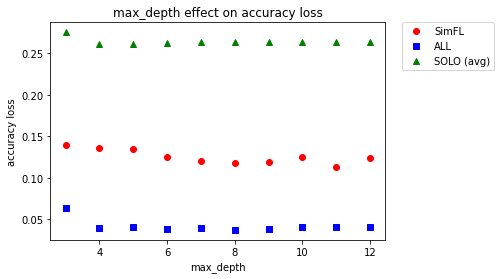

In [ ]:
# Max depth
parameter = 'max_depth'
tune_range = np.arange(3, 13, 1)

params = {'max_depth': 8, 'n_estimators': 100, 'colsample_bytree': 0.8, 'subsample': 0.8, 'nthread': 10, 'learning_rate': 0.1}
max_depth_tune = tune_param(X, y, parameter, tune_range, params, num_parties = 3, L = None)
plot_tuning(max_depth_tune[0], tune_range,parameter)

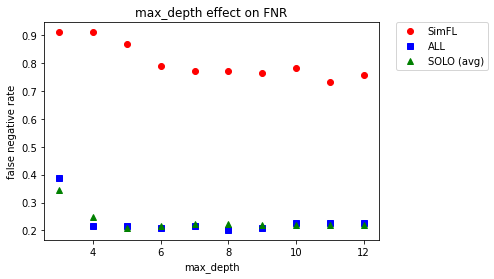

In [ ]:
plot_fnr(max_depth_tune[1], tune_range,parameter)

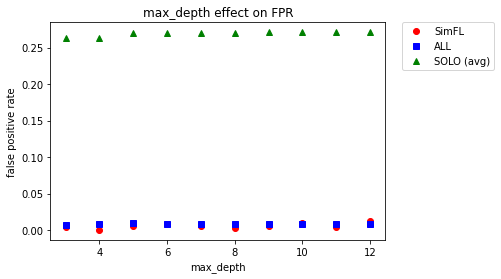

In [ ]:
plot_fpr(max_depth_tune[2], tune_range,parameter)

Start

Start

Start

Start



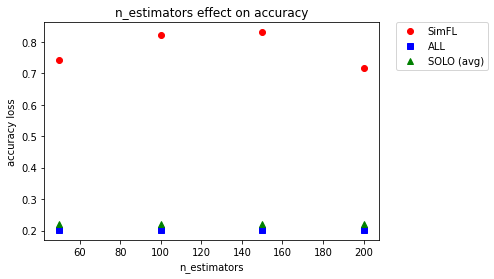

In [ ]:
# Number of estimators
parameter = 'n_estimators'
tune_range = np.arange(50, 250, 50)

params = {'max_depth': 8, 'n_estimators': 100, 'colsample_bytree': 0.8, 'subsample': 0.8, 'nthread': 10, 'learning_rate': 0.1}
n_est_tune = tune_param(X, y, parameter, tune_range, params, num_parties = 3, L = None)
plot_tuning(n_est_tune[1], tune_range,parameter)

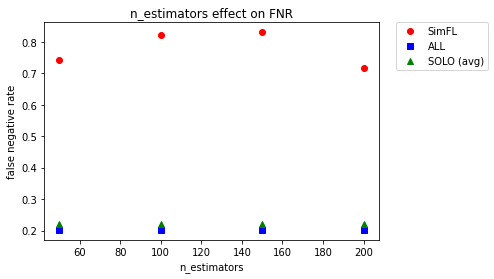

In [ ]:
plot_fnr(n_est_tune[1], tune_range,parameter)

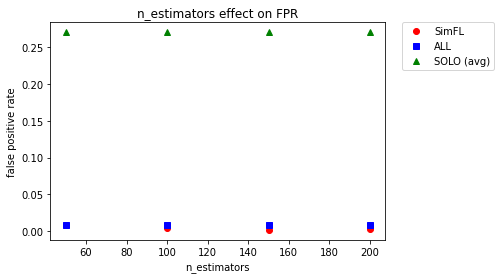

In [ ]:
plot_fpr(n_est_tune[2], tune_range,parameter)

Start

Start

Start

Start

Start



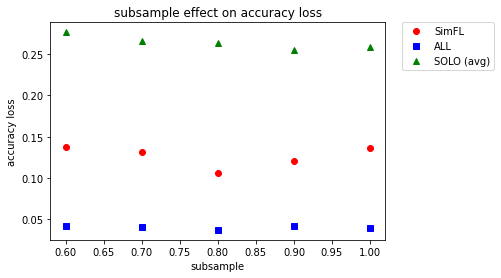

In [ ]:
# Subsample
parameter = 'subsample'
tune_range = np.arange(.6,1.01,.1)

params = {'max_depth': 8, 'n_estimators': 100, 'colsample_bytree': 0.8, 'subsample': 0.8, 'nthread': 10, 'learning_rate': 0.1}
subsamp_tune = tune_param(X, y, parameter, tune_range, params, num_parties = 3, L = None)
plot_tuning(subsamp_tune[0], tune_range, parameter)

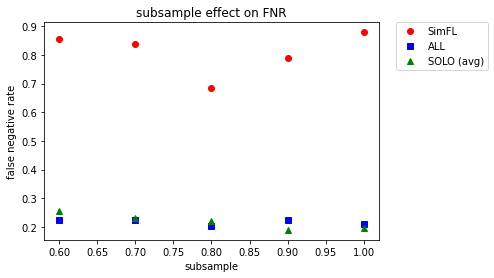

In [ ]:
plot_fnr(subsamp_tune[1], tune_range, parameter)

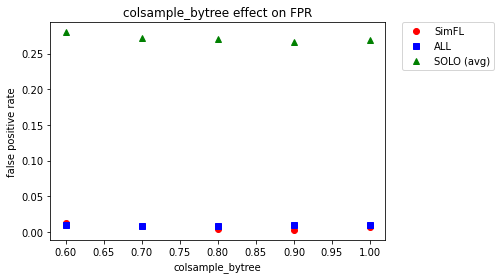

In [ ]:
plot_fpr(subsamp_tune[2], tune_range, parameter)

Start

Start

Start

Start

Start



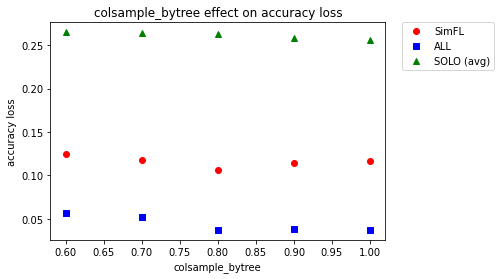

In [ ]:
# colsample_bytree
parameter = 'colsample_bytree'
tune_range = np.arange(.6,1.01,.1)

params = {'max_depth': 8, 'n_estimators': 100, 'colsample_bytree': 0.8, 'subsample': 0.8, 'nthread': 10, 'learning_rate': 0.1}
colsamp_tune = tune_param(X, y, parameter, tune_range, params, num_parties = 3, L = None)
plot_tuning(colsamp_tune[0], tune_range, parameter)

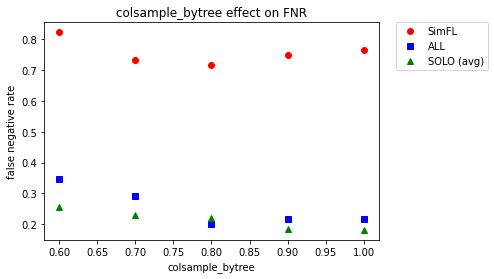

In [ ]:
plot_fnr(colsamp_tune[1], tune_range, parameter)

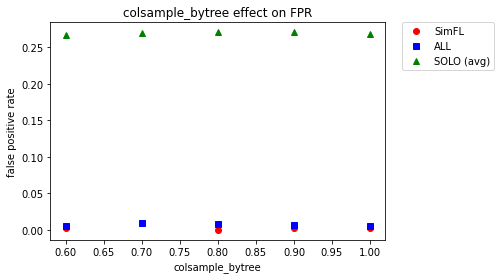

In [ ]:
plot_fpr(colsamp_tune[2], tune_range, parameter)

In [ ]:
print(max_depth_tune)
print(n_est_tune)
print(subsamp_tune)
print(colsamp_tune)

([[0.13925570228091236, 0.06362545018007203, 0.27521008403361347], [0.13565426170468187, 0.03961584633853541, 0.26140456182472993], [0.13445378151260504, 0.04081632653061224, 0.2608043217286915], [0.12484993997599039, 0.03841536614645858, 0.26260504201680673], [0.12004801920768307, 0.03961584633853541, 0.26320528211284516], [0.11764705882352941, 0.03721488595438175, 0.26320528211284516], [0.11884753901560624, 0.03841536614645858, 0.26320528211284516], [0.12484993997599039, 0.04081632653061224, 0.26320528211284516], [0.11284513805522209, 0.04081632653061224, 0.26320528211284516], [0.12364945978391356, 0.04081632653061224, 0.26320528211284516]], [[0.9112903225806451, 0.3870967741935484, 0.3467741935483871], [0.9112903225806451, 0.21774193548387097, 0.25], [0.8709677419354839, 0.21774193548387097, 0.20967741935483872], [0.7903225806451613, 0.20967741935483872, 0.21774193548387094], [0.7741935483870968, 0.21774193548387097, 0.2217741935483871], [0.7741935483870968, 0.20161290322580644, 0.2

### SHAP Column Demo on SimFL

The goal of this code section is to create a SHAP column explainer that describes the top *b* contributors (i.e. a list of features) to each prediction. 

In [ ]:
pip install shap

  Using cached https://files.pythonhosted.org/packages/a8/77/b504e43e21a2ba543a1ac4696718beb500cfa708af2fb57cb54ce299045c/shap-0.35.0.tar.gz
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394119 sha256=e36880b6effe0b23ae67a7d578c970a88abe5fc9d51cca8fdd77b0af5aef9d6d
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [ ]:
import shap

In [ ]:
# returns an array of predicted examples, their predicted labels, pre-rounded predictions, and SHAP explanation
def shap_output(model, X, features, predictions, labels, b = 3, numeric = True): 
    shap_vals = get_shap_vals(model, X) 
    col = shap_col(shap_vals, features, b, numeric) 

    fields = features
    fields.append('Predicted Label (churn = 1)') # Label = prediction rounded to 0 or 1
    fields.append('Pre-rounded prediction') # Can think of as (sigmoid of) probability of churning
    fields.append('Prediction explanation (SHAP)') 
    
    rows = np.hstack((np.array(X), np.array([labels]).T, np.array([predictions]).T, np.array([col]).T))

    return list(np.vstack((np.array(fields), rows)))

def get_shap_vals(model, X):
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X) 
    return shap_vals

# Given an n-by-m array of SHAP values, 
# returns a column of descriptions. 
# The ith entry of the last column describes the top b features that contribute
# to the prediction for the ith example. 
def shap_col(shap_values, features, b = 3, numeric = True): 
    if b > len(shap_values[0]): b = len(shap_values[0])
    col = []
    fts = features
    fts = np.array(fts)
    for row in shap_values:
        inds = np.argsort(-np.absolute(np.array(row)))
        inds = inds[:b]
        top_fts = list(fts[inds])
        top_fts_vals = list(np.array(row)[inds])

        describe = 'The top ' + str(b) + ' feature(s) contributing to this prediction are: '
        for i in range(b):
            feat = top_fts[i]
            describe = describe + feat

            # numeric option returns SHAP values of top contributing features
            if numeric == True:
                val = top_fts_vals[i]
                describe = describe + ' (' + str(val) + ')'
            
            if i != b-1: describe = describe + '; '
        
        col.append(describe)
    
    return col


In [ ]:
# Demo of SHAP column for SimFL
def shap_demo(X, y, features, params = {'max_depth': 8}, num_parties = 3, L = None, hash_output = False, verbose = False):

    # print('Start\n')
    if verbose: print('XGBoost parameters: ', params, '; Number of Parties: ', num_parties)
    
    # Randomizing X, y and separating train/test sets randomly
    holdout_X, X, holdout_y, y = train_test_split(X, y, train_size=0.001, random_state=42)

    vectors=[]
    # print("Original number of data points: ", len(X))

    for j in range(0, int(len(X)), int(len(X)/num_parties)):
        partyX = []
        partyY = []
        for i in range(j, min(j+int(len(X)/num_parties), int(len(X)))):
            partyX.append(X[i])
            partyY.append(y[i])
        vectors.append((partyX, partyY))

    hash_tables = hash(vectors, X, y, L, hash_output, verbose)

    num_parties = len(vectors)
    if verbose: print("Data points per party: ", len(vectors[0][0]))

    xgb_parties = []
    for party in vectors:
        xgb_parties.append(xgb.DMatrix(np.asarray(party[0]), label=np.asarray(party[1])))
    
    model = xgb.Booster(params, [xgb_parties[0]])

    G = []
    H = []
    for i in range(len(vectors)):
        G.append([])
        H.append([])
    
    for m in tqdm(range(2*len(vectors)), disable = not verbose): #Select central processing party that receives gradients from others
        m_ind = m % len(vectors)
        for i in range(len(vectors)): 
            if i != m_ind:
                Gi = np.zeros((len(vectors), len(vectors[m_ind][0])))
                Hi = np.zeros((len(vectors), len(vectors[m_ind][0])))
                for q in range(len(vectors[i][0])):
                    s = int(hash_tables[i][q][m_ind])
                    dtrain = xgb.DMatrix(np.asarray([vectors[i][0][q]]), label=np.asarray([vectors[i][1][q]]))
                    dpred_inst = model.predict(dtrain)
                    grad, hess = cust_obj(dpred_inst, dtrain)
                    Gi[m_ind][s] += grad
                    Hi[m_ind][s] += hess
                G[i] = Gi
                H[i] = Hi
        Gm = np.zeros((len(vectors), len(vectors[m_ind][0])))
        Hm = np.zeros((len(vectors), len(vectors[m_ind][0])))
        for q in range(len(vectors[m_ind][0])):
            for i in range(len(vectors)):
                if i == m_ind:
                    dtrain = xgb.DMatrix(np.asarray([vectors[m_ind][0][q]]), label=np.asarray([vectors[m_ind][1][q]]))
                    dpred_inst = model.predict(dtrain)
                    grad, hess = cust_obj(dpred_inst, dtrain)
                    Gm[m_ind][q] += grad
                    Hm[m_ind][q] += hess
                else:
                    Gm[m_ind][q] += G[i][m_ind][q]
                    Hm[m_ind][q] += H[i][m_ind][q]
        G[m_ind] = Gm
        H[m_ind] = Hm
        
        m_dtrain = xgb_parties[m_ind]
        model.boost(m_dtrain, Gm[m_ind], Hm[m_ind])
    
    # SimFL: federated data sets
    dtest = xgb.DMatrix(np.asarray(holdout_X[:int(len(holdout_X))]), label=np.asarray(holdout_y[:int(len(holdout_y))]))
    test_preds = model.predict(dtest)
    test_preds = sigmoid(test_preds)
    test_preds_labels = np.round(test_preds)

    output = shap_output(model, holdout_X, features, test_preds, test_preds_labels)

    return output


In [ ]:
# simple demo using ALL (no SimFL)
def shap_demo_test1(X, y, features, params = {'max_depth': 8}, num_parties = 3, L = None, hash_output = False, verbose = False):

    # print('Start\n')
    if verbose: print('XGBoost parameters: ', params, '; Number of Parties: ', num_parties)
    
    # Randomizing X, y, and separating train/test sets randomly
    holdout_X, X, holdout_y, y = train_test_split(X, y, train_size=0.001, random_state=42)
  
    dtest = xgb.DMatrix(np.asarray(holdout_X[:int(len(holdout_X))]), label=np.asarray(holdout_y[:int(len(holdout_y))]))
    dtrainAll = xgb.DMatrix(np.asarray(X[:int(len(X))]), label=np.asarray(y[:int(len(y))]))
    paramsAll = params
    modelAll = xgb.Booster(params, [dtrainAll])
    for i in tqdm(range(20), disable = not verbose):
        predictions = modelAll.predict(dtrainAll)
        g,h = cust_obj(predictions, dtrainAll)
        modelAll.boost(dtrainAll,g,h)
    test_preds_all = modelAll.predict(dtest)
    test_preds_all = sigmoid(test_preds_all)
    test_preds_labels_all = np.round(test_preds_all)

    output = shap_output(modelAll, holdout_X, features, test_preds_all, test_preds_labels_all)

    return output

In [ ]:
test = shap_demo(X,y,features,verbose = True)

XGBoost parameters:  {'max_depth': 8} ; Number of Parties:  3


  0%|          | 0/3 [00:00<?, ?it/s]


Building hash tables:

0


 33%|███▎      | 1/3 [00:14<00:28, 14.44s/it]

1


 67%|██████▋   | 2/3 [00:28<00:14, 14.44s/it]

2


  0%|          | 0/6 [00:00<?, ?it/s]

Data points per party:  1110


100%|██████████| 6/6 [00:02<00:00,  2.74it/s]
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
print(test)

[array(['state', 'account length', 'area code', 'international plan',
       'voice mail plan', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls',
       'Predicted Label (churn = 1)', 'Pre-rounded prediction',
       'Prediction explanation (SHAP)'], dtype='<U152'), array(['37.0', '66.0', '408.0', '0.0', '0.0', '0.0', '87.6', '76.0',
       '14.89', '262.0', '111.0', '22.27', '184.6', '125.0', '8.31',
       '9.2', '5.0', '2.48', '1.0', '0.0', '0.15468569',
       'The top 3 feature(s) contributing to this prediction are: total eve minutes (0.11746291); account length (-0.11171901); total day minutes (-0.108136564)'],
      dtype='<U152'), array(['11.0', '169.0', '415.0', '0.0', '0.0', '0.0', '179.2', '111.0',
  

In [ ]:
# name of csv file  
filename = "SHAPresults.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile) 
        
    # writing the data rows  
    csvwriter.writerows(test) 